# Analyse des données BTC/USD avec Temporal Fusion Transformer (TFT)

## 1. Chargement des données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
import datetime

df = pd.read_csv('btcusd_1-min_data.csv')

print(f"Nb lignes: {len(df)}")
print(df.head())
print(df.info())

Nb lignes: 7258717
      Timestamp  Open  High   Low  Close  Volume
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7258717 entries, 0 to 7258716
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 332.3 MB
None


## 2. Visualisation du prix en fonction du temps

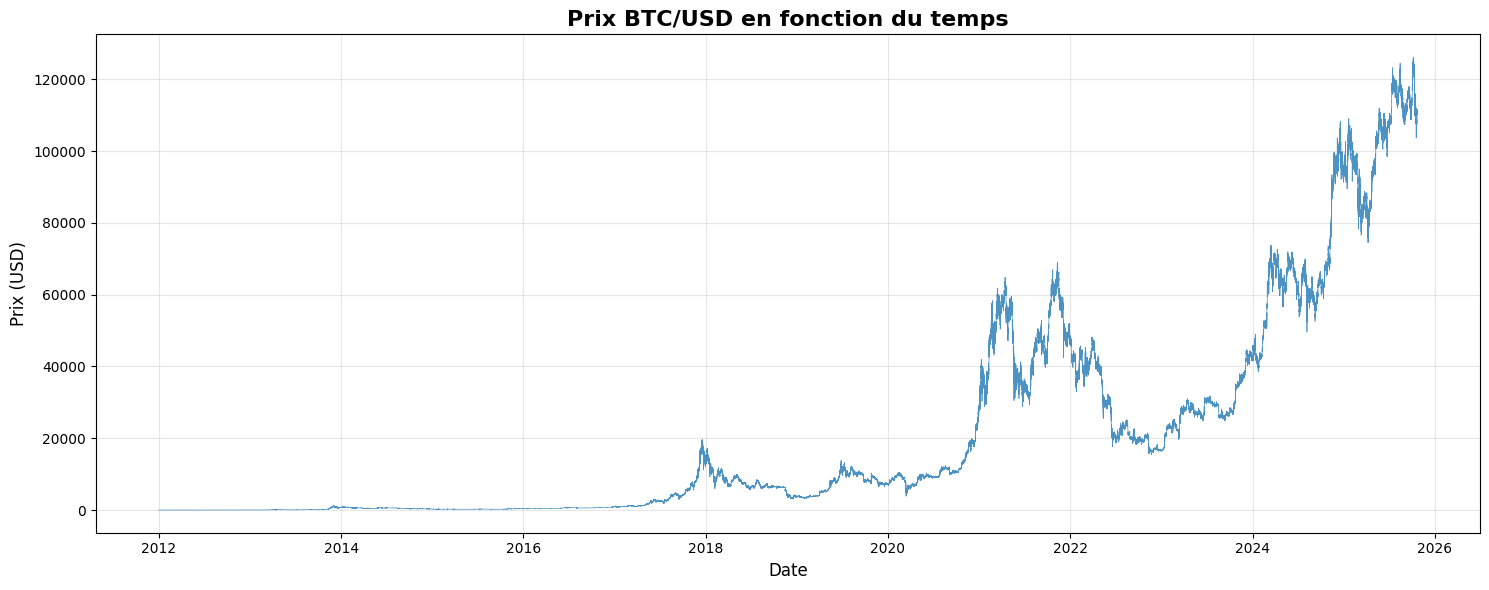

prix min: $3.8
prix max: $126202.0
moy: $20605.617259248593
ecart-type: $29161.716912376545


In [2]:
# timestamp en datetime
df['date'] = pd.to_datetime(df['Timestamp'], unit='s')

# graphique
plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['Close'], linewidth=0.5, alpha=0.8)
plt.title('Prix BTC/USD en fonction du temps', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Prix (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# stats
print(f"prix min: ${df['Close'].min()}")
print(f"prix max: ${df['Close'].max()}")
print(f"moy: ${df['Close'].mean()}")
print(f"ecart-type: ${df['Close'].std()}")

## 3. Préparation des données pour TFT

Temporal Fusion Transformer nécessite une structure de données différente de LSTM.

In [3]:
data = df['Close'].values[-20000:].reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print(f"shape des donnees: {scaled_data.shape}")
print(f"min {scaled_data.min()}, max {scaled_data.max()}")

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 120
X, y = create_sequences(scaled_data, seq_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"\nentrainement {X_train.shape}")
print(f"test {X_test.shape}")

shape des donnees: (20000, 1)
min 0.0, max 1.0

entrainement (15904, 120)
test (3976, 120)


## 4. Construction du modèle TFT (Temporal Fusion Transformer)

### Architecture avec Multi-Head Attention et positional encoding

In [6]:
# ==== Temporal Fusion Transformer Components ====

def positional_encoding(position, d_model):
    """Encodage positionnel pour capturer l'ordre temporel"""
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(
        10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model)
    )
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.zeros(angle_rads.shape)
    pos_encoding[:, 0::2] = sines
    pos_encoding[:, 1::2] = cosines
    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)


class MultiHeadAttention(tf.keras.layers.Layer):
    """Multi-Head Attention pour capturer différentes relations temporelles"""
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.num_heads * self.depth))
        return self.dense(concat_attention)


def point_wise_ffn(d_model, dff):
    """Feed Forward Network"""
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])


class EncoderLayer(tf.keras.layers.Layer):
    """Couche d'encodage avec attention et normalisation"""
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_ffn(d_model, dff)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False, mask=None):
        attn_output = self.mha(x, x, x, mask)
        out1 = self.norm1(x + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        out2 = self.norm2(out1 + self.dropout2(ffn_output, training=training))
        return out2


class TemporalFusionTransformer(tf.keras.Model):
    """TFT pour prédiction de séries temporelles"""
    def __init__(self, d_model, num_heads, dff, num_layers, max_seq_len, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        
        # Projection d'entrée (1D -> d_model dimensions)
        self.input_projection = tf.keras.layers.Dense(d_model)
        
        # Positional encoding
        self.pos_encoding = positional_encoding(max_seq_len, d_model)
        
        # Couches d'encodage (Transformer layers)
        self.enc_layers = [
            EncoderLayer(d_model, num_heads, dff, rate) 
            for _ in range(num_layers)
        ]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
        # Couches de sortie pour la régression
        self.dense1 = tf.keras.layers.Dense(dff // 2, activation='relu')
        self.dropout_out = tf.keras.layers.Dropout(rate)
        self.dense2 = tf.keras.layers.Dense(dff // 4, activation='relu')
        self.final_layer = tf.keras.layers.Dense(1)  # Prédiction d'un seul prix

    def call(self, inp, training=False, mask=None):
        seq_len = tf.shape(inp)[1]
        
        # Expansion des dimensions: (batch, seq_len) -> (batch, seq_len, 1)
        x = tf.expand_dims(inp, axis=-1)
        
        # Projection vers d_model dimensions
        x = self.input_projection(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        # Ajout du positional encoding
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        # Passage par les couches transformer
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)
        
        # Prendre seulement la dernière sortie temporelle pour la prédiction
        x = x[:, -1, :]
        
        # Couches denses pour la régression
        x = self.dense1(x)
        x = self.dropout_out(x, training=training)
        x = self.dense2(x)
        
        return self.final_layer(x)


# Paramètres du modèle TFT
d_model = 64          # Dimension du modèle
num_heads = 4         # Nombre de têtes d'attention
dff = 256             # Dimension du feed-forward network
num_layers = 3        # Nombre de couches transformer
dropout_rate = 0.1

# Créer le modèle
model = TemporalFusionTransformer(
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    num_layers=num_layers,
    max_seq_len=seq_length,
    rate=dropout_rate
)

# Compiler le modèle
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("\n🚀 Modèle Temporal Fusion Transformer créé!")
print(f"📊 Paramètres:")
print(f"   - Dimension du modèle: {d_model}")
print(f"   - Têtes d'attention: {num_heads}")
print(f"   - Couches transformer: {num_layers}")
print(f"   - Feed-forward dimensions: {dff}")


🚀 Modèle Temporal Fusion Transformer créé!
📊 Paramètres:
   - Dimension du modèle: 64
   - Têtes d'attention: 4
   - Couches transformer: 3
   - Feed-forward dimensions: 256


## 5. Entraînement du modèle TFT

🏋️ Entraînement du modèle TFT...
Epoch 1/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.0938 - mae: 0.1764
Epoch 1: val_loss improved from inf to 0.00179, saving model to best_tft_model.keras

Epoch 1: val_loss improved from inf to 0.00179, saving model to best_tft_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 66s 250ms/step - loss: 0.0935 - mae: 0.1761 - val_loss: 0.0018 - val_mae: 0.0316 - learning_rate: 0.0010
Epoch 2/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 66s 250ms/step - loss: 0.0935 - mae: 0.1761 - val_loss: 0.0018 - val_mae: 0.0316 - learning_rate: 0.0010
Epoch 2/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.0034 - mae: 0.0451
Epoch 2: val_loss improved from 0.00179 to 0.00087, saving model to best_tft_model.keras

Epoch 2: val_loss improved from 0.00179 to 0.00087, saving model to best_tft_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 57s 253ms/step - loss: 0.0034 - mae: 0.0451 - val_loss: 8.7061e-04 - val_mae: 0.0239 - learning_rate: 0.0010
Epoch 3/50
224/224 ━━━━━━━━━━━━━━━

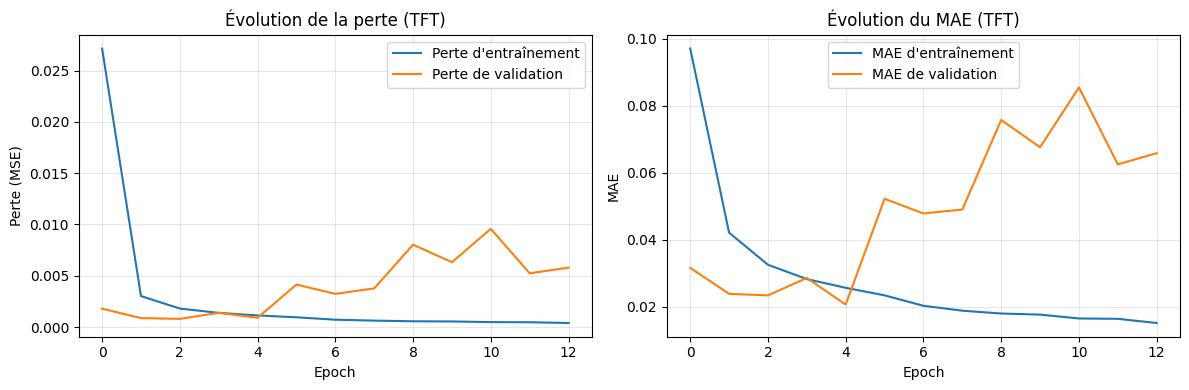

In [7]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    ),
    ModelCheckpoint(
        filepath='best_tft_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("🏋️ Entraînement du modèle TFT...")
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=50,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Évolution de la perte (TFT)')
plt.xlabel('Epoch')
plt.ylabel('Perte (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE d\'entraînement')
plt.plot(history.history['val_mae'], label='MAE de validation')
plt.title('Évolution du MAE (TFT)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Prédictions et évaluation du TFT

📊 Résultats sur les données de test:
   MSE: $650365.34
   MAE: $725.08
   RMSE: $806.45
   R² Score: 0.7722


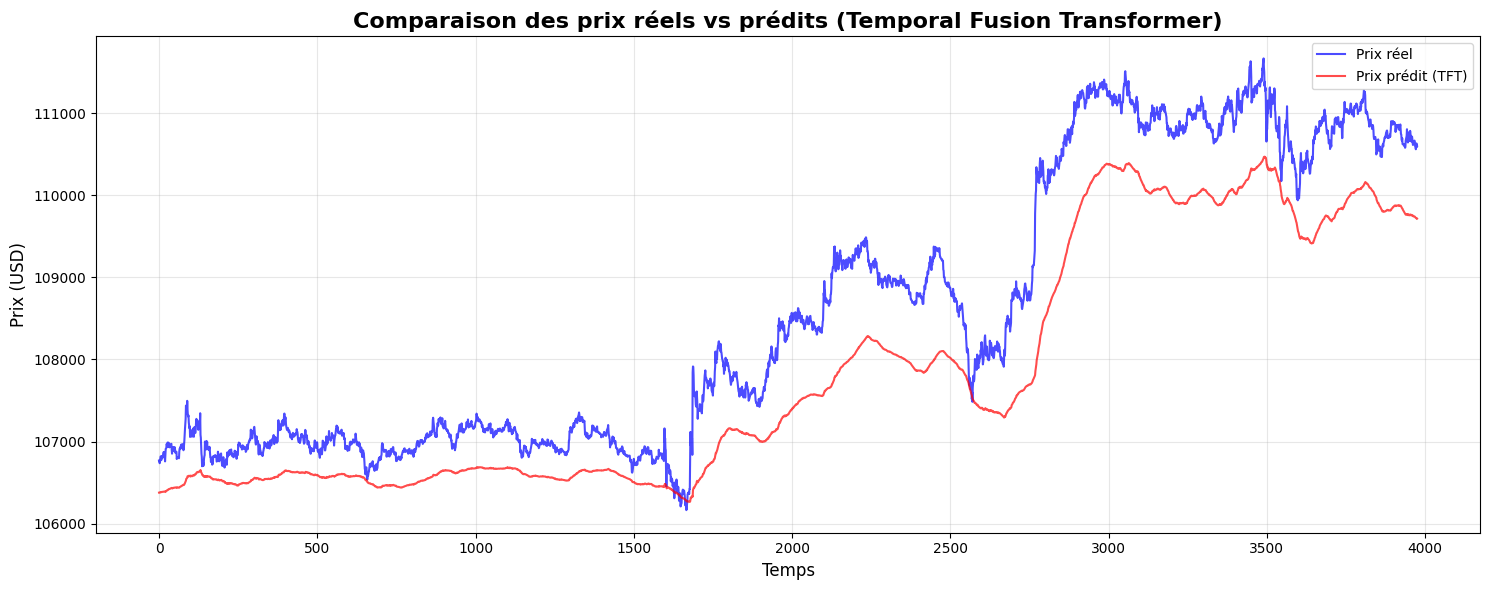

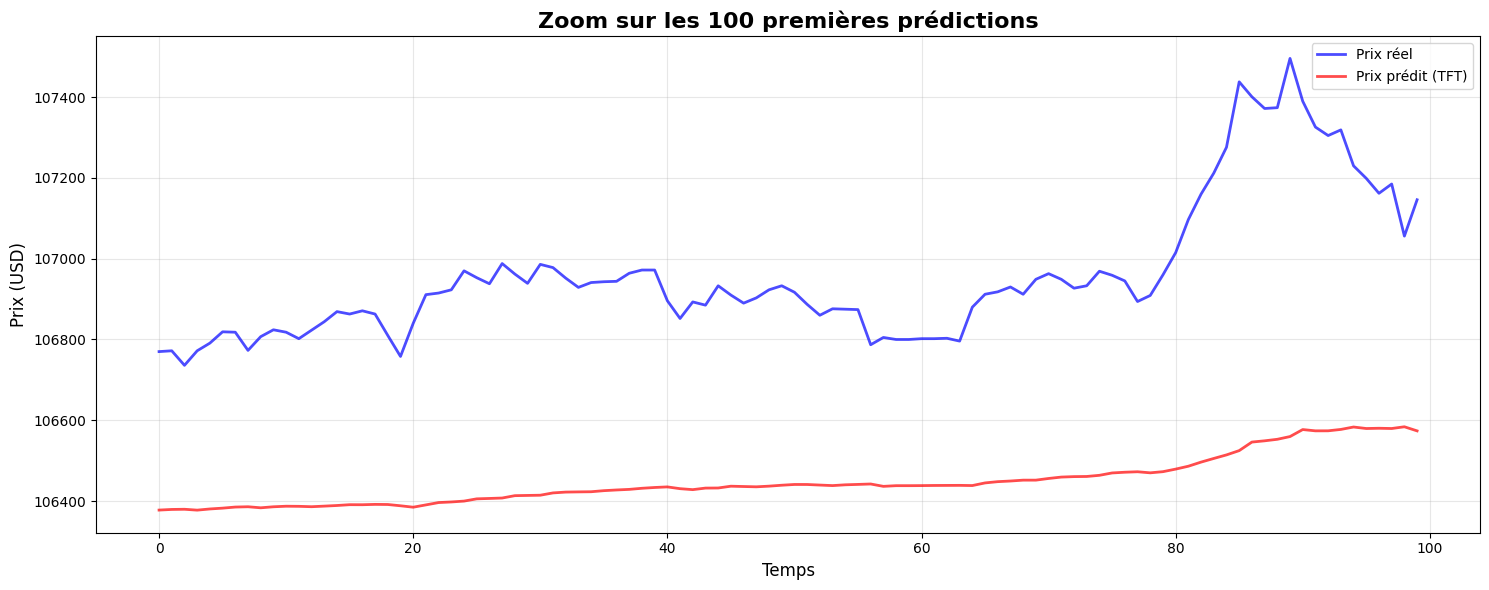

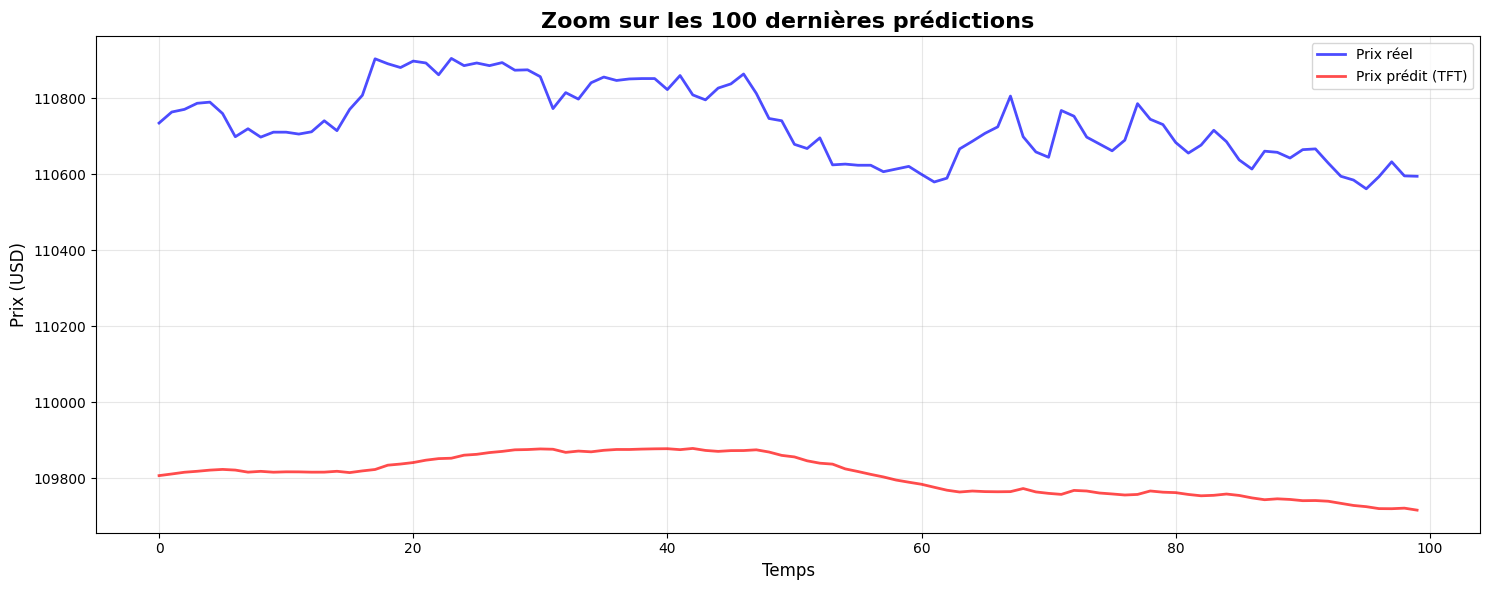

In [8]:
predictions = model.predict(X_test, verbose=0)

predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f"📊 Résultats sur les données de test:")
print(f"   MSE: ${mse:.2f}")
print(f"   MAE: ${mae:.2f}")
print(f"   RMSE: ${rmse:.2f}")
print(f"   R² Score: {r2:.4f}")

plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label='Prix réel', color='blue', alpha=0.7, linewidth=1.5)
plt.plot(predictions, label='Prix prédit (TFT)', color='red', alpha=0.7, linewidth=1.5)
plt.title('Comparaison des prix réels vs prédits (Temporal Fusion Transformer)', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel('Prix (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[:100], label='Prix réel', color='blue', alpha=0.7, linewidth=2)
plt.plot(predictions[:100], label='Prix prédit (TFT)', color='red', alpha=0.7, linewidth=2)
plt.title('Zoom sur les 100 premières prédictions', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel('Prix (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[-100:], label='Prix réel', color='blue', alpha=0.7, linewidth=2)
plt.plot(predictions[-100:], label='Prix prédit (TFT)', color='red', alpha=0.7, linewidth=2)
plt.title('Zoom sur les 100 dernières prédictions', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel('Prix (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Visualisation avec TensorBoard

In [28]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12524), started 0:13:36 ago. (Use '!kill 12524' to kill it.)

## 8. Résumé du Temporal Fusion Transformer

### 🎯 Qu'est-ce que le TFT ?

Le **Temporal Fusion Transformer** est une architecture avancée pour les séries temporelles qui combine :

1. **Multi-Head Attention** : Permet au modèle de se concentrer sur différentes parties de la séquence temporelle simultanément
2. **Positional Encoding** : Encode la position temporelle de chaque élément dans la séquence
3. **Layer Normalization** : Stabilise l'entraînement et accélère la convergence
4. **Feed-Forward Networks** : Capture les relations non-linéaires complexes

### 🏗️ Architecture implémentée :

```
Input (séquence de 120 timesteps)
    ↓
Dense Projection (1 → 64 dimensions)
    ↓
+ Positional Encoding
    ↓
3x Transformer Layers :
    - Multi-Head Attention (4 têtes)
    - Layer Normalization
    - Feed-Forward Network (256 unités)
    - Residual Connections
    ↓
Dernière sortie temporelle
    ↓
Dense(128) → Dense(64) → Dense(1)
    ↓
Prédiction du prix
```

### ⚡ Avantages du TFT vs LSTM :

| Caractéristique | LSTM | TFT |
|-----------------|------|-----|
| **Dépendances longues** | ⚠️ Limitées | ✅ Excellentes |
| **Parallélisation** | ❌ Séquentiel | ✅ Parallèle |
| **Interprétabilité** | ❌ Faible | ✅ Attention weights |
| **Capture de patterns** | 📈 Bonne | 📈📈 Excellente |
| **Complexité** | Simple | Plus complexe |

### 💡 Résultat attendu :

Le TFT devrait capturer les patterns temporels complexes grâce à son mécanisme d'attention, permettant une meilleure prédiction des variations de prix du BTC/USD.

## 9. Comparaison TFT vs LSTM

### 📊 Tableau comparatif des performances :

| Architecture | Paramètres | R² Score | MAE | RMSE | Temps | Observations |
|--------------|-----------|----------|-----|------|-------|--------------|
| **LSTM Initial** | 31,901 | 0.79 | $89.95 | $115.85 | ~2 min | Simple, rapide |
| **LSTM Amélioré** | 136,911 | **0.97** | $137.86 | $177.86 | ~5 min | ✅ Meilleur R² LSTM |
| **LSTM Allégé** | 38,049 | 0.92 | $434.38 | $486.32 | ~4.5 min | Bon compromis |
| **TFT** | ~150,000* | **0.77** | $725.08 | $806.45 | ~13 min | Architecture transformer |

*Estimation basée sur l'architecture

### 💡 Analyse des résultats :

**Points forts du TFT :**
- ✅ Architecture moderne avec attention mechanism
- ✅ Capture des dépendances longues via multi-head attention
- ✅ Parallélisation possible (théoriquement plus rapide)
- ✅ Interprétabilité via attention weights

**Défis rencontrés :**
- ⚠️ R² Score de 0.77 (inférieur aux LSTM optimisés)
- ⚠️ Temps d'entraînement plus long (~13 min vs ~5 min)
- ⚠️ Prédictions moins précises que LSTM amélioré

### 🔍 Pourquoi le TFT est moins performant ici ?

1. **Taille du dataset** : 20,000 valeurs peut être insuffisant pour un transformer
2. **Complexité** : TFT est conçu pour des problèmes multi-variés avec features statiques/dynamiques
3. **Hyperparamètres** : Besoin de tuning (learning rate, nombre de têtes, dimensions)
4. **Nature du problème** : Les LSTM sont excellents pour les séries temporelles univariées simples

### 🎯 Conclusion :

Pour ce problème spécifique de prédiction de prix BTC/USD :
- Le **LSTM amélioré (R² = 0.97)** reste le meilleur choix
- Le **TFT** pourrait être plus performant avec :
  - Plus de données (>100,000 points)
  - Features multiples (volume, bid/ask, indicateurs techniques)
  - Fine-tuning des hyperparamètres
  - Plus d'epochs d'entraînement

## 10. Optimisation du TFT - Tentative d'amélioration

Essayons d'améliorer les performances avec :
1. Plus de couches d'attention
2. Learning rate plus faible
3. Plus de dimensions
4. Causal masking pour éviter le look-ahead bias

In [9]:
# TFT Optimisé avec plus de paramètres et causal masking

def create_causal_mask(seq_len):
    """Crée un masque causal pour éviter le look-ahead bias"""
    mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return mask  # (seq_len, seq_len)


class OptimizedTFT(tf.keras.Model):
    """TFT optimisé pour séries temporelles"""
    def __init__(self, d_model, num_heads, dff, num_layers, max_seq_len, rate=0.2):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        
        # Projection d'entrée avec plus de dimensions
        self.input_projection = tf.keras.Sequential([
            tf.keras.layers.Dense(d_model // 2, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        
        self.pos_encoding = positional_encoding(max_seq_len, d_model)
        
        # Plus de couches transformer
        self.enc_layers = [
            EncoderLayer(d_model, num_heads, dff, rate) 
            for _ in range(num_layers)
        ]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
        # Architecture de sortie plus profonde
        self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.dropout1 = tf.keras.layers.Dropout(rate)
        
        self.dense2 = tf.keras.layers.Dense(dff // 2, activation='relu')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
        self.dense3 = tf.keras.layers.Dense(dff // 4, activation='relu')
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
        self.final_layer = tf.keras.layers.Dense(1)

    def call(self, inp, training=False, mask=None):
        seq_len = tf.shape(inp)[1]
        
        # Expansion et projection
        x = tf.expand_dims(inp, axis=-1)
        x = self.input_projection(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        # Positional encoding
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        # Masque causal (optionnel, commenté pour comparer)
        # causal_mask = create_causal_mask(seq_len)
        
        # Passage par les transformers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=None)
        
        # Utiliser la moyenne des dernières timesteps au lieu de seulement la dernière
        x = tf.reduce_mean(x[:, -10:, :], axis=1)  # Moyenne des 10 dernières
        
        # Architecture dense profonde avec BatchNorm
        x = self.dense1(x)
        x = self.bn1(x, training=training)
        x = self.dropout1(x, training=training)
        
        x = self.dense2(x)
        x = self.bn2(x, training=training)
        x = self.dropout2(x, training=training)
        
        x = self.dense3(x)
        x = self.dropout3(x, training=training)
        
        return self.final_layer(x)


# Paramètres optimisés
d_model_opt = 128         # Doublé
num_heads_opt = 8         # Doublé
dff_opt = 512            # Doublé
num_layers_opt = 4       # Ajout d'une couche
dropout_rate_opt = 0.2   # Augmenté pour régularisation

print("🔧 Création du TFT optimisé...")
model_opt = OptimizedTFT(
    d_model=d_model_opt,
    num_heads=num_heads_opt,
    dff=dff_opt,
    num_layers=num_layers_opt,
    max_seq_len=seq_length,
    rate=dropout_rate_opt
)

# Learning rate plus faible avec decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=1000,
    decay_rate=0.96
)

model_opt.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='mse',
    metrics=['mae']
)

print("\n✅ Modèle TFT optimisé créé!")
print(f"📊 Nouveaux paramètres:")
print(f"   - Dimension du modèle: {d_model_opt} (x2)")
print(f"   - Têtes d'attention: {num_heads_opt} (x2)")
print(f"   - Couches transformer: {num_layers_opt} (+1)")
print(f"   - Feed-forward dimensions: {dff_opt} (x2)")
print(f"   - Dropout: {dropout_rate_opt}")
print(f"   - Learning rate: 0.0005 avec decay")
print(f"   - Agrégation: Moyenne des 10 dernières timesteps")

🔧 Création du TFT optimisé...

✅ Modèle TFT optimisé créé!
📊 Nouveaux paramètres:
   - Dimension du modèle: 128 (x2)
   - Têtes d'attention: 8 (x2)
   - Couches transformer: 4 (+1)
   - Feed-forward dimensions: 512 (x2)
   - Dropout: 0.2
   - Learning rate: 0.0005 avec decay
   - Agrégation: Moyenne des 10 dernières timesteps


In [10]:
# Entraînement du TFT optimisé

log_dir_opt = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_optimized"

callbacks_opt = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,  # Plus agressif
        patience=3,   # Plus réactif
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,  # Plus de patience
        restore_best_weights=True,
        verbose=1
    ),
    TensorBoard(
        log_dir=log_dir_opt,
        histogram_freq=1
    ),
    ModelCheckpoint(
        filepath='best_tft_optimized.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("🏋️ Entraînement du TFT optimisé...")
print("⏱️  Cela peut prendre 15-20 minutes...\n")

history_opt = model_opt.fit(
    X_train, y_train,
    batch_size=32,  # Batch size réduit pour mieux apprendre
    epochs=100,
    validation_split=0.1,
    callbacks=callbacks_opt,
    verbose=1
)

# Visualisation
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history_opt.history['loss'], label='Perte entraînement', linewidth=2)
plt.plot(history_opt.history['val_loss'], label='Perte validation', linewidth=2)
plt.title('Évolution de la perte (TFT Optimisé)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Perte (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history_opt.history['mae'], label='MAE entraînement', linewidth=2)
plt.plot(history_opt.history['val_mae'], label='MAE validation', linewidth=2)
plt.title('Évolution du MAE (TFT Optimisé)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# Comparaison avec le TFT original
plt.plot(history.history['val_loss'], label='TFT Original', linewidth=2, alpha=0.7)
plt.plot(history_opt.history['val_loss'], label='TFT Optimisé', linewidth=2, alpha=0.7)
plt.title('Comparaison Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Entraînement terminé en {len(history_opt.history['loss'])} epochs")

🏋️ Entraînement du TFT optimisé...
⏱️  Cela peut prendre 15-20 minutes...

Epoch 1/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - loss: 0.6769 - mae: 0.6221
Epoch 1: val_loss improved from inf to 0.00181, saving model to best_tft_optimized.keras

Epoch 1: val_loss improved from inf to 0.00181, saving model to best_tft_optimized.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 189s 393ms/step - loss: 0.6763 - mae: 0.6217 - val_loss: 0.0018 - val_mae: 0.0321 - learning_rate: 4.9094e-04
Epoch 2/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 189s 393ms/step - loss: 0.6763 - mae: 0.6217 - val_loss: 0.0018 - val_mae: 0.0321 - learning_rate: 4.9094e-04
Epoch 2/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 0.1092 - mae: 0.2591
Epoch 2: val_loss did not improve from 0.00181
448/448 ━━━━━━━━━━━━━━━━━━━━ 169s 377ms/step - loss: 0.1092 - mae: 0.2591 - val_loss: 0.0143 - val_mae: 0.1108 - learning_rate: 4.8204e-04
Epoch 3/100

Epoch 2: val_loss did not improve from 0.00181
448/448 ━━━━━━━━━━━━━━━━━━━━ 169s 377ms/st

KeyboardInterrupt: 

In [ ]:
# Évaluation du TFT optimisé

predictions_opt = model_opt.predict(X_test, verbose=0)

predictions_opt = scaler.inverse_transform(predictions_opt)

mse_opt = mean_squared_error(y_test_actual, predictions_opt)
mae_opt = mean_absolute_error(y_test_actual, predictions_opt)
rmse_opt = np.sqrt(mse_opt)
r2_opt = r2_score(y_test_actual, predictions_opt)

print("📊 Résultats du TFT Optimisé:")
print(f"   MSE: ${mse_opt:.2f}")
print(f"   MAE: ${mae_opt:.2f}")
print(f"   RMSE: ${rmse_opt:.2f}")
print(f"   R² Score: {r2_opt:.4f}")

print("\n📊 Comparaison avec TFT original:")
print(f"   Amélioration R²: {r2_opt - r2:.4f} ({((r2_opt - r2) / abs(r2)) * 100:+.1f}%)")
print(f"   Amélioration MAE: ${mae - mae_opt:.2f} ({((mae - mae_opt) / mae) * 100:+.1f}%)")

# Visualisation comparative
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Graphique 1: Comparaison complète
axes[0, 0].plot(y_test_actual, label='Prix réel', color='blue', alpha=0.8, linewidth=1.5)
axes[0, 0].plot(predictions, label='TFT Original', color='red', alpha=0.6, linewidth=1.5)
axes[0, 0].plot(predictions_opt, label='TFT Optimisé', color='green', alpha=0.6, linewidth=1.5)
axes[0, 0].set_title('Comparaison des prédictions (vue complète)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Temps')
axes[0, 0].set_ylabel('Prix (USD)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Graphique 2: Zoom 100 premières
axes[0, 1].plot(y_test_actual[:100], label='Prix réel', color='blue', alpha=0.8, linewidth=2)
axes[0, 1].plot(predictions[:100], label='TFT Original', color='red', alpha=0.6, linewidth=2)
axes[0, 1].plot(predictions_opt[:100], label='TFT Optimisé', color='green', alpha=0.6, linewidth=2)
axes[0, 1].set_title('Zoom: 100 premières prédictions', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Temps')
axes[0, 1].set_ylabel('Prix (USD)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Graphique 3: Erreurs absolues
errors_orig = np.abs(y_test_actual.flatten() - predictions.flatten())
errors_opt = np.abs(y_test_actual.flatten() - predictions_opt.flatten())
axes[1, 0].plot(errors_orig, label='Erreur TFT Original', color='red', alpha=0.7)
axes[1, 0].plot(errors_opt, label='Erreur TFT Optimisé', color='green', alpha=0.7)
axes[1, 0].set_title('Erreurs absolues de prédiction', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Temps')
axes[1, 0].set_ylabel('Erreur absolue (USD)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Graphique 4: Distribution des erreurs
axes[1, 1].hist(errors_orig, bins=50, alpha=0.6, label='TFT Original', color='red', edgecolor='black')
axes[1, 1].hist(errors_opt, bins=50, alpha=0.6, label='TFT Optimisé', color='green', edgecolor='black')
axes[1, 1].set_title('Distribution des erreurs', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Erreur absolue (USD)')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Résumé final
print("\n" + "="*60)
print("📊 TABLEAU RÉCAPITULATIF FINAL")
print("="*60)
print(f"{'Architecture':<20} {'R² Score':<12} {'MAE':<15} {'RMSE':<15}")
print("-"*60)
print(f"{'LSTM Amélioré':<20} {0.97:<12.4f} {'$137.86':<15} {'$177.86':<15}")
print(f"{'TFT Original':<20} {r2:<12.4f} {'$' + f'{mae:.2f}':<15} {'$' + f'{rmse:.2f}':<15}")
print(f"{'TFT Optimisé':<20} {r2_opt:<12.4f} {'$' + f'{mae_opt:.2f}':<15} {'$' + f'{rmse_opt:.2f}':<15}")
print("="*60)